iLQR in jax. 
 * Cost
 * Derivatives
 * Q terms, gains, V-terms

In [2]:
import jax
from jax import numpy as np
from jax.lax import scan
from jax import vmap, jit

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("RdYlBu", 8)

import sys
sys.path.append("../src/")
import arm_model

## Model

In [3]:
with open('../data/arm_dt10.pickle', 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())
m_trj = 100 * d['torques']

dict_keys(['torques', 'positions', 'states'])


In [4]:
x_trj, y_trj = arm_model.rollout_batch(arm_model.x0, m_trj)

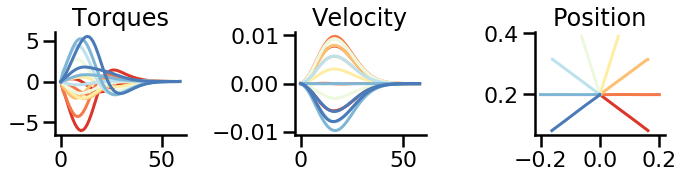

In [5]:
f, ax = plt.subplots(1,3, figsize=(10,3))
for i in range(8):
    ax[0].plot(m_trj[i], c=sns.color_palette()[i])
    ax[1].plot(np.diff(y_trj[i], axis=0), c=sns.color_palette()[i])
    ax[2].plot(y_trj[i,:,0], y_trj[i,:,1])
    
ax[0].set_title("Torques")
ax[1].set_title("Velocity")
ax[2].set_title("Position")
sns.despine()
f.tight_layout()

## Cost function

In [6]:
def cost_stage(x, u, target, lmbda):
    # x: [theta1, theta2, thetadot1, thetadot2]
    # u: [u1, u2]
    # target: [theta1*, theta2*]
    state_cost = np.sum((x[:2] - target)**2)
    control_cost = np.sum(u**2)
    return state_cost + lmbda * control_cost

def cost_final(x, target):
    return np.sum((x[:2] - target)**2)
    
cost_stage_trj = vmap(cost_stage, in_axes=(0,0,0,None))
cost_stage_batch = vmap(cost_stage_trj, in_axes=(0,0,0,None))
print(cost_stage(x_trj[0,0], m_trj[0,0], x_trj[0,0,:2]+1, 1e-2))
print(cost_stage_trj(x_trj[0], m_trj[0], x_trj[0,:,:2]+1, 1e-2).sum())
print(cost_stage_batch(x_trj, m_trj, x_trj[:,:,:2]+1, 1e-2).sum())

2.0000122
123.81331
977.06006


In [7]:
cost_stage(x_trj[0,0], m_trj[0,0], x_trj[0,0, :2]+2, 0), cost_final(x_trj[0,0], x_trj[0,0,:2]+1)

(DeviceArray(8., dtype=float32), DeviceArray(1.9999999, dtype=float32))

In [8]:
def cost_trj(x_trj, u_trj, target_trj, lmbda):
    # x_trj: (time_steps, state dim)
    c_stage = cost_stage_trj(x_trj[:-1], u_trj[:-1], target_trj[:-1], lmbda) 
    c_final = cost_final(x_trj[-1], target_trj[-1])
    return c_stage + c_final

In [9]:
x_trj = np.zeros((100, 4))
u_trj = np.zeros((100, 2))
target_trj = np.zeros((100, 2))
cost_trj(x_trj, u_trj, target_trj, 1e-1)

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Derivatives

In [10]:
from jax import jacobian, jacfwd, jacrev, hessian

In [11]:
def cost_stage_grads(x, u, target, lmbda):
    # x = [theta1, theta2, thetadot1, thetadot2]
    # u = [u1, u2]
    # target = [theta1*, theta2*]
    
    dL = jacrev(cost_stage, (0,1)) #l_x, l_u
    d2L = jacfwd(dL, (0,1)) # l_xx etc
    
    l_x, l_u = dL(x, u, target, lmbda)
    d2Ldx, d2Ldu = d2L(x, u, target, lmbda)
    l_xx, l_xu = d2Ldx
    l_ux, l_uu = d2Ldu
    
    return l_x, l_u, l_xx, l_ux, l_uu

t = 10
cost_stage_grads_batch = jit(vmap(cost_stage_grads, in_axes=(0,0,0,None))) # e.g. (batch size, 4)
#l_x, l_u, l_xx, l_ux, l_uu = cost_stage_grads(x_trj[0,t], m_trj[0,t], x_trj[0,t,:2]+2, 1e-2)
#l_x, l_u, l_xx, l_ux, l_uu = cost_stage_grads_batch(x_trj[:,t], m_trj[:,t], x_trj[:,t,:2]+2, 1e-2)

In [12]:
def cost_final_grads(x, target):
    # x = [theta1, theta2, thetadot1, thetadot2]
    # target = [theta1*, theta2*]
    
    dL = jacrev(cost_final) #l_x, l_u
    d2L = jacfwd(dL) # l_xx etc
    
    l_x = dL(x, target)
    l_xx = d2L(x, target)
    
    return l_x, l_xx

cost_final_grad_batch = jit(vmap(cost_final_grads, in_axes=(0,0))) # e.g. (batch size, 4)
#t = 10
#l_x, l_xx = cost_final_grad_batch(x_trj[:,t], x_trj[:,t, :2]+2)

Dynamics

In [13]:
def dynamics_grads(f, x, u):
    # (n_x, n_u), (n_x, n_u)
    f_x, f_u = jacfwd(f, (0,1))(x,u)
    return f_x, f_u


def f(x, m):
    dt = .1
    xnew = x + dt*arm_model.continuous_dynamics(x, m)
    return xnew
  
dynamics_grads_batch = vmap(dynamics_grads, (None,0,0))
b, t = 0,10
#print(x_trj[b,t])
#print(m_trj[b,t])
#print()
#f_x, f_u = dynamics_grads(f, x_trj[b, t], m_trj[b, t])
#f_x, f_u = dynamics_grads_batch(f, x_trj[:, t], m_trj[:, t])
#print(f_x.shape)

In [14]:
def Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx):
    # TODO: Define the Q-terms here
    Q_x = np.zeros(l_x.shape) + l_x.T + V_x.T @ f_x 
    Q_u = np.zeros(l_u.shape) + l_u.T + V_x.T @ f_u 
    Q_xx = np.zeros(l_xx.shape) + l_xx + f_x.T @ V_xx @ f_x #
    Q_ux = np.zeros(l_ux.shape) + l_ux + f_u.T @ V_xx @ f_x #
    Q_uu = np.zeros(l_uu.shape) + l_uu + f_u.T @ V_xx @ f_u #
    return Q_x, Q_u, Q_xx, Q_ux, Q_uu

In [15]:
import numpy as onp
rng = onp.random.RandomState(123)
x = rng.normal(size=(4, ))
u = rng.normal(size=(2, ))
target = rng.normal(size=(2, ))
V_x = rng.normal(size=(4, ))#np.zeros_like(x)
V_xx = rng.normal(size=(4, 4))
# 
l_x = rng.normal(size=(4,))
l_u = rng.normal(size=(2, ))
l_ux = rng.normal(size=(2,4))
l_xx = rng.normal(size=(4,4))
l_uu = rng.normal(size=(2,2))
f_x = rng.normal(size=(4, 4))
f_u = rng.normal(size=(4, 2))
Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
#print(Q_xx)

In [16]:
def gains(Q_uu, Q_u, Q_ux):
    Q_uu_inv = np.linalg.inv(Q_uu)
    # TOD: Implement the feedforward gain k and feedback gain K.
    k = np.zeros(Q_u.shape) - Q_uu_inv @ Q_u
    K = np.zeros(Q_ux.shape) - Q_uu_inv @ Q_ux
    return k, K

k, K = gains(Q_uu, Q_u, Q_ux)
gains_batched = vmap(gains, (0,0,0))
#k, K = gains_batched(Q_uu, Q_u, Q_ux)
#print(k)
#print()
#print(K)

In [17]:
def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    # TODO: Implement V_x and V_xx, hint: use the A.dot(B) function for matrix multiplcation.
    V_x  = np.zeros(Q_x.shape) + Q_x.T + Q_u.T @ K + k @ Q_ux + k.T @ Q_uu @ K
    V_xx = np.zeros(Q_xx.shape) + Q_xx + K.T @ Q_ux + Q_ux.T @ K + K.T @ Q_uu @ K
    return V_x, V_xx

V_terms_batched = vmap(V_terms, (0,0,0,0,0,0,0))
V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
#print(V_x)
#print()
#print(V_xx)

In [18]:
def expected_cost_reduction(Q_u, Q_uu, k):
    return -Q_u.T.dot(k) - 0.5 * k.T.dot(Q_uu.dot(k))

expected_cost_reduction_batch = vmap(expected_cost_reduction, (0,0,0))
print(expected_cost_reduction(Q_u, Q_uu, k))

-3.7418811


## Forward pass

In [19]:
def forward_pass(x_trj, u_trj, k_trj, K_trj):
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0,:] = x_trj[0,:]
    u_trj_new = np.zeros(u_trj.shape)
    # TODO: Implement the forward pass here
    for n in range(u_trj.shape[0]-1):
        u_trj_new[n,:] = u_trj[n] + k_trj[n] + K_trj[n]@(x_trj_new[n] - x_trj[n])# Apply feedback law
        x_trj_new[n+1,:] = discrete_dynamics(x_trj_new[n], u_trj_new[n]) # Apply dynamics
    return x_trj_new, u_trj_new

In [20]:
def forward_pass(x_trj, u_trj, k_trj, K_trj):
    # x_trj: (time steps, 4)
    x_trj_new = [x_trj[0]]
    u_trj_new = []
    for n in range(u_trj.shape[0]-1):
        u_trj_new.append(u_trj[n] + k_trj[n] + K_trj[n]@(x_trj_new[-1] - x_trj[n]))
        x_trj_new.append(arm_model.discrete_dynamics(x_trj_new[-1], u_trj_new[-1])[1]) # Apply dynamics
    return x_trj_new, u_trj_new

In [21]:
def discrete_dynamics_affine(xt_new, xt, ut, kt, Kt):
    ut_new = ut + kt + Kt@(xt_new - xt)
    return ut_new, arm_model.discrete_dynamics(xt_new, ut_new)[1]

In [22]:
def forward_pass(x_trj, inputs_t):
    # x_trj: (time steps, 4)
    u_trj, k_trj, K_trj = inputs_t
    x_trj_new = [x_trj[0]]
    u_trj_new = []
    for n in range(u_trj.shape[0]-1):
        u_new, x_new = discrete_dynamics_affine(x_trj_new[-1], x_trj[n], u_trj[n], k_trj[n], K_trj[n])
        x_trj_new.append(x_new)
        u_trj_new.append(u_new)
        #u_trj_new.append(u_trj[n] + k_trj[n] + K_trj[n]@(x_trj_new[-1] - x_trj[n]))
        #x_trj_new.append(arm_model.discrete_dynamics(x_trj_new[-1], u_trj_new[-1])[1]) # Apply dynamics
    return x_trj_new, u_trj_new

In [23]:
rng = onp.random.RandomState(123)
time_steps = 10
x_trj = rng.normal(size=(time_steps, 4))
u_trj = rng.normal(size=(time_steps, 2))
k_trj = rng.normal(size=(time_steps, 2))
K_trj = rng.normal(size=(time_steps, 2, 4))
x_trj_new, u_trj_new = forward_pass(x_trj, (u_trj, k_trj, K_trj))
print(x_trj_new[-1]) #print(x_trj[-1])()
print(u_trj_new[-1])
print(len(x_trj_new), len(u_trj_new))

[-0.86793965  0.04031817 -0.08081166  0.02565168]
[0.4797015 1.2913607]
10 9


In [24]:
def discrete_dynamics_affine(xs, inputs):
    ut, xt_new = xs[:2], xs[2:]
    xt, ut, kt, Kt = inputs
    ut_new = ut + kt + Kt@(xt_new - xt)
    xt_new2 = arm_model.discrete_dynamics(xt_new, ut_new)[1]
    res = np.concatenate((ut_new, xt_new2))
    # Throw away the last ut, add first input
    return res, res 

In [25]:
def forward_pass_scan(x_trj, u_trj, k_trj, K_trj):
    inputs = (x_trj, u_trj, k_trj, K_trj)
    init = np.concatenate((np.zeros_like(u_trj[0]), x_trj[0]))
    states  = scan(discrete_dynamics_affine, init, (x_trj, u_trj, k_trj, K_trj))[1]
    u_trj_new, x_trj_new = states[:,:2], states[:-1,2:]
    x_trj_new = np.concatenate((x_trj[0][None], x_trj_new), axis=0)
    return u_trj_new, x_trj_new

forward_pass_jit = jit(forward_pass_scan)
# Batch over x, u, and feedback
forward_pass_batch = jit(vmap(forward_pass_scan, (0,0,0,0))) 

In [26]:
u_trj_new, x_trj_new = forward_pass_jit(x_trj, u_trj, k_trj, K_trj)

Backward pass

In [30]:
def step_back(x_t, u_t, target_t, V_x, V_xx, regu, lmbda):
    l_x, l_u, l_xx, l_ux, l_uu = cost_stage_grads(x_t, u_t, target_t, lmbda)
    f_x, f_u = dynamics_grads(f, x_t, u_t)
    Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
    Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
    k, K = gains(Q_uu_regu, Q_u, Q_ux)
    V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
    return k, K, V_x, V_xx

def backward_pass(x_trj, u_trj, target_trj, regu, lmbda):
    # x_trj: (time steps, state dim.)
    k_trj, K_trj = [], []
    # Init. the derivatives
    l_final_x, l_final_xx = cost_final_grads(x_trj[-1], target_trj[-1])
    V_x = l_final_x
    V_xx = l_final_xx
    # Loop
    for n in range(u_trj.shape[0]-1, -1, -1):
        k, K, V_x, V_xx = step_back(x_trj[n], u_trj[n], target_trj[n], V_x, V_xx, regu, lmbda)
        k_trj.append(k)
        K_trj.append(K)
    return np.array(k_trj), np.array(K_trj)

#k, K, V_x, V_xx = step_back(x_trj[0,-1], u_trj[-1], x_trj[0,-1,:2], np.zeros((4, )), np.zeros((4,4)), 1e-1, 1e-1)
#k_trj, K_trj = backward_pass(x_trj, u_trj, x_trj[:,:2], 1e-1, 1e-1)

In [31]:
def dynamics_grads(f, x, u):
    # (n_x, n_u), (n_x, n_u)
    f_x, f_u = jacfwd(f, (0,1))(x,u)
    return f_x, f_u


def discrete_dynamics(x, m):
    dt = .1
    xnew = x + dt*arm_model.continuous_dynamics(x, m)
    return xnew
  
dynamics_grads_batch = vmap(dynamics_grads, (None,0,0))
b, t = 0, 0
f_x, f_u = dynamics_grads(discrete_dynamics, x_trj[t], u_trj[t])

In [32]:
def step_back_scan(state, inputs, regu, lmbda):
    #regu, lmbda = 1e-1, 1e-1
    x_t, u_t, target_t = inputs
    k, K, V_x, V_xx = state
    l_x, l_u, l_xx, l_ux, l_uu = cost_stage_grads(x_t, u_t, target_t, lmbda)
    f_x, f_u = dynamics_grads(discrete_dynamics, x_t, u_t)
    Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
    Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
    k, K = gains(Q_uu_regu, Q_u, Q_ux)
    V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
    new_state = (k, K, V_x, V_xx)
    return new_state, new_state

def backward_pass_scan(x_trj, u_trj, target_trj, regu, lmbda):
    # Init
    n_x, n_u = x_trj.shape[1], u_trj.shape[1]
    k, K = np.zeros((n_u, )), np.zeros((n_u, n_x))
    l_final_x, l_final_xx = cost_final_grads(x_trj[-1], target_trj[-1])
    V_x = l_final_x
    V_xx = l_final_xx
    # Wrap initial state and inputs for use in scan
    init = (k, K, V_x, V_xx)
    xs = (x_trj, u_trj, target_trj)
    # Loop
    step_fn = lambda state, inputs: step_back_scan(state, inputs, regu, lmbda)
    _, state = scan(step_fn, init, xs, reverse=True)
    k_trj, K_trj, _, _ = state
    return k_trj, K_trj

backward_pass_jit = jit(backward_pass_scan)

In [33]:
k, K = backward_pass_jit(x_trj, x_trj[:,:2], x_trj[:,:2],1e-1, 1e-1)

In [86]:
with open("../data/arm_dt10.pickle", 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())

dict_keys(['torques', 'positions', 'states'])


## Main loop

In [132]:
import time

def run_ilqr(x0, target_trj, u_trj = None, max_iter=10, regu_init=10, lmbda=1e-1):
    # First forward rollout
    if u_trj is None:
        N = target_trj.shape[0]
        n_u = 2
        u_trj = onp.random.normal(size=(N, n_u)) * 0.0001
    x_trj, y_trj = arm_model.rollout(x0, u_trj)
    total_cost = cost_trj(x_trj, u_trj, target_trj, lmbda).sum()
    regu = regu_init
    
    cost_trace = [total_cost]
    
    # Run main loop
    t0 = time.time()
    for it in range(max_iter):
        # Backward and forward pass
        k_trj, K_trj = backward_pass_jit(x_trj, u_trj, target_trj, regu, lmbda)
        u_trj_new, x_trj_new = forward_pass_jit(x_trj, u_trj, k_trj, K_trj)
        # Evaluate new trajectory
        total_cost = cost_trj(x_trj_new, u_trj_new, target_trj, lmbda).sum()
        t1 = time.time()
        
        # 
        cost_redu = cost_trace[-1] - total_cost
        cost_trace.append(total_cost)
        # Accept or reject iteration
        """
        if cost_redu > 0:
            # Improvement! Accept new trajectories and lower regularization
            cost_trace.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new
            regu *= 0.5
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
            cost_trace.append(cost_trace[-1])
        """
        #if it%1 == 0:
        #    print(it, total_cost, cost_redu)
        dur = time.time() - t0
    return x_trj_new, u_trj_new, np.array(cost_trace)

run_ilqr_batch = jit(vmap(run_ilqr, (0, 0, 0, None, None, None)), static_argnums=3)
# To do:

In [115]:
with open("../data/arm_dt10.pickle", 'rb') as handle:
    d = pickle.load(handle)

In [201]:
m_trj = d['torques']*100 #onp.random.normal(size= d['torques'].shape) 
x0 = d['states'][:,0]
target_trj = d['states'][:,:,:2]
u_trj, x_trj = arm_model.rollout(x0[0], m_trj[0])

regu = 0.0
lmbda = 1e-4
x_trj_new, u_trj_new, cost_trace = run_ilqr(x0[0], target_trj[0], m_trj[0], 10, regu, lmbda)
print(cost_trace)

[0.03818756 0.03811427 0.03811427 0.03811427 0.03811427 0.03811427
 0.03811427 0.03811427 0.03811427 0.03811427 0.03811427]


Beter: vmap forward & backward. Then keep track of individual traces. Increase regularization when needed.

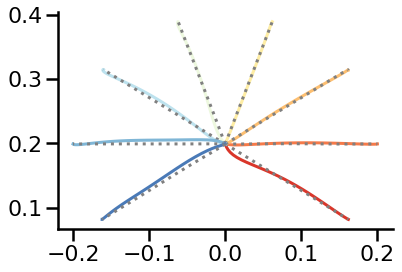

In [202]:
for i in range(8):
    x0 = d['states'][i,0]
    target_trj = d['states'][i,:,:2]
    x_trj_new, u_trj_new, cost_trace = run_ilqr(x0, target_trj, None, 10, regu, lmbda)
    
    y_trj_new = arm_model.get_position_trj(x_trj_new)
    plt.plot(y_trj_new[:,0], y_trj_new[:,1])
    y_target = arm_model.get_position_trj(d['states'][i])
    plt.plot(y_target[:,0], y_target[:,1],":", color='gray')
sns.despine()